<a href="https://colab.research.google.com/github/tianxiang84/PINN-elastodynamics/blob/wave_1d_rod/ElasticWaveRod/PINN_Rod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [1]:
# Platform-related functions
import platform
# System specific functions
import sys
# Dealing with I/O streams
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# Time-related functions
import time
# File operation
import shutil
# Serializing and de-serializing a Python object structure
import pickle

# Setup GPU for training
%tensorflow_version 1.x
import tensorflow as tf
tf.set_random_seed(1111)
# Math functions defined in C standard
import math
# Multi-dimensional array calculation
import numpy as np
np.random.seed(1111)
# Data analysis and manipulation
import pandas as pd
# Dealing with MATLAB files
import scipy.io
# Desig n of experiments for Python
!pip install --upgrade pyDOE
from pyDOE import lhs

# For plotting
import matplotlib
if platform.system()=='Linux':
    matplotlib.use('Agg')
if platform.system()=='Windows':
    from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

TensorFlow 1.x selected.
  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=034653870b1564f7bae47381202af8980778652842db87c698fc90f624785258
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


Check GPU availability (On Google Colab, please use Runtime --> Change runtime type is you see an empty list as output.)

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

Functions to generate rows of samples: x, y, t, u, v, s11, s22, s12

In [3]:
def GenDistPt(xmin, xmax, ymin, ymax, tmin, tmax, xc, yc, r, num_surf_pt, num, num_t):
    # Function to generate discret points in the x-y-t domain
    # First generate a uniform x-y grid
    # Then delete the points in the hole
    # Then add the points lining the hole
    # Finally add time dimension points

    # num: number per edge
    # num_t: number time step

    x = np.linspace(xmin, xmax, num=num)
    y = np.linspace(ymin, ymax, num=num)
    x, y = np.meshgrid(x, y)

    # Delete point in hole
    dst = ((x - xc) ** 2 + (y - yc) ** 2) ** 0.5
    x = x[dst >= r]
    y = y[dst >= r]
    x = x.flatten()[:, None]
    y = y.flatten()[:, None]

    # Refinement point near hole surface
    theta = np.linspace(0.0, np.pi / 2.0, num_surf_pt)
    x_surf = np.multiply(r, np.cos(theta)) + xc
    y_surf = np.multiply(r, np.sin(theta)) + yc
    x_surf = x_surf.flatten()[:, None]
    y_surf = y_surf.flatten()[:, None]
    x = np.concatenate((x, x_surf), 0)
    y = np.concatenate((y, y_surf), 0)

    # Cartisian product with time points
    t = np.linspace(tmin, tmax, num=num_t)
    xxx, ttt = np.meshgrid(x, t)
    yyy,   _ = np.meshgrid(y, t)
    xxx = xxx.flatten()[:, None]
    yyy = yyy.flatten()[:, None]
    ttt = ttt.flatten()[:, None]
    return xxx, yyy, ttt

def GenDist(XYT_dist):
    # Pass in XYT, outptu XYT, u, v, s11, s22, s12
    
    dist_u = np.zeros_like(XYT_dist[:, 0:1]) # Return an array of zeros with the same shape and type as a given array.
    dist_v = np.zeros_like(XYT_dist[:, 0:1])
    dist_s11 = np.zeros_like(XYT_dist[:, 0:1])
    dist_s22 = np.zeros_like(XYT_dist[:, 0:1])
    dist_s12 = np.zeros_like(XYT_dist[:, 0:1])

    for i in range(len(XYT_dist)):
        dist_u[i, 0] = min(XYT_dist[i][2], XYT_dist[i][0])  # min(t, x-(-0.5))
        dist_v[i, 0] = min(XYT_dist[i][2], XYT_dist[i][1])  # min(t, sqrt((x+0.5)^2+(y+0.5)^2))
        dist_s11[i, 0] = min(XYT_dist[i][2], 0.5 - XYT_dist[i][0])
        dist_s22[i, 0] = min(XYT_dist[i][2], 0.5 - XYT_dist[i][1])  # min(t, 0.5-y, 0.5+y)
        dist_s12[i, 0] = min(XYT_dist[i][2], XYT_dist[i][1], 0.5 - XYT_dist[i][1], XYT_dist[i][0], 0.5 - XYT_dist[i][0])
    
    DIST = np.concatenate((XYT_dist, dist_u, dist_v, dist_s11, dist_s22, dist_s12), 1)

    return DIST

def DelHolePT(XYT_c, xc=0, yc=0, r=0.1):
    # Input rows of points [x,y,t]
    # Delete points within hole
    # Return only the points outside the hole
    
    dst = np.array([((xyt[0] - xc) ** 2 + (xyt[1] - yc) ** 2) ** 0.5 for xyt in XYT_c])

    return XYT_c[dst > r, :]


def GenHoleSurfPT(xc, yc, r, N_PT):
    # Generate
    theta = np.linspace(0.0, np.pi / 2.0, N_PT)
    xx = np.multiply(r, np.cos(theta)) + xc
    yy = np.multiply(r, np.sin(theta)) + yc
    xx = xx.flatten()[:, None]
    yy = yy.flatten()[:, None]
    return xx, yy

Parameters

In [4]:
PI = math.pi
MAX_T = 10.0

# Domain bounds for x, y and t
lb = np.array([0.0, 0.0,   0.0]) # lower bounds for (x,y,t)
ub = np.array([0.5, 0.5, MAX_T]) # upper bounds for (x,y,t)

# Network configuration
uv_layers   = [3] + 8 * [70] + [5] #list [3, 70, ...., 70, 5]
dist_layers = [3] + 4 * [20] + [5]
part_layers = [3] + 4 * [20] + [5]

# ????????????????????????????????? #
# Number of frames for postprocessing
N_t = int(MAX_T * 8 + 1) #integer: 81

In [7]:
# Generate distance function for spatio-temporal space
x_dist, y_dist, t_dist = GenDistPt(xmin=0, xmax=0.5, ymin=0, ymax=0.5, tmin=0, tmax=10, xc=0, yc=0, r=0.1,
                                       num_surf_pt=40, num=21, num_t=21)
# x_dist: (9786,1)
# y_dist: (9786,1)
# t_dist: (9786,1)

XYT_dist = np.concatenate((x_dist, y_dist, t_dist), 1)
# XYT_dist: (9786,3) (x1,y1,t1; x2,y2,t2)

# ????????????????????????????????? #
DIST = GenDist(XYT_dist)
# XYT, u, v, s11, s22, s12
# DIST: (9786, 8)

# Initial condition points for u, v
IC = lb + np.array([0.5, 0.5, 0.0]) * lhs(3, 5000) #Latin hypercube sampling
IC = DelHolePT(IC, xc=0, yc=0, r=0.1) # Delete the points in the hole

# IC: not deterministic, e.g, (4833,3), filtered from (5000, 3)
# [x1,y1,0]
# [x2,y2,0]

# Collocation point for equation residual: x in (0, 0.5) , y in (0, 0.5)
XYT_c = lb + (ub - lb) * lhs(3, 70000)
XYT_c_ref = lb + np.array([0.15, 0.15, 10.0]) * lhs(3, 40000)  # Refinement for stress concentration
XYT_c = np.concatenate((XYT_c, XYT_c_ref), 0)
XYT_c = DelHolePT(XYT_c, xc=0, yc=0, r=0.1)

# XYT_c.shape = (93831,3)

# Points along the hole (center at 0, 0, radius is 0.1)
xx, yy = GenHoleSurfPT(xc=0, yc=0, r=0.1, N_PT=83)
tt = np.linspace(0, 10, 121)
tt = tt[1:] # Delete the first point
x_ho, t_ho = np.meshgrid(xx, tt)
y_ho, _ = np.meshgrid(yy, tt)
x_ho = x_ho.flatten()[:, None]
y_ho = y_ho.flatten()[:, None]
t_ho = t_ho.flatten()[:, None]
HOLE = np.concatenate((x_ho, y_ho, t_ho), 1)

# Boundary points
LW = np.array([0.1, 0.0, 0.0]) + np.array([0.4, 0.0, 10]) * lhs(3, 8000)
UP = np.array([0.0, 0.5, 0.0]) + np.array([0.5, 0.0, 10]) * lhs(3, 8000)
LF = np.array([0.0, 0.1, 0.0]) + np.array([0.0, 0.4, 10]) * lhs(3, 8000)
RT = np.array([0.5, 0.0, 0.0]) + np.array([0.0, 0.5, 10]) * lhs(3, 13000)

t_RT = RT[:, 2:3]
period = 5  # two period in 10s
s11_RT = 0.5 * np.sin((2 * PI / period) * t_RT + 3 * PI / 2) + 0.5
RT = np.concatenate((RT, s11_RT), 1)
# RT has the shape of (13000,4) now: x, y, t and (s11_t?)

# Add some boundary points into the collocation point set
XYT_c = np.concatenate((XYT_c, HOLE[::4, :], LF[::5, :], RT[::5, 0:3], UP[::5, :], LW[::5, :]), 0)

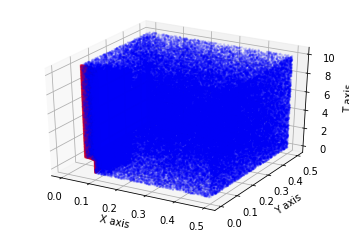

In [8]:
# Visualize ALL the training points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XYT_c[:,0:1], XYT_c[:,1:2], XYT_c[:,2:3], marker='o', alpha=0.1, s=2, color='blue')
ax.scatter(IC[:, 0:1], IC[:, 1:2], IC[:, 2:3], marker='o', alpha=0.1, s=2, color='blue')
ax.scatter(LW[:, 0:1], LW[:, 1:2], LW[:, 2:3], marker='o', alpha=0.1, s=2, color='blue')
ax.scatter(UP[:, 0:1], UP[:, 1:2], UP[:, 2:3], marker='o', alpha=0.1, s=2, color='blue')
ax.scatter(LF[:, 0:1], LF[:, 1:2], LF[:, 2:3], marker='o', alpha=0.1, s=2, color='blue')
ax.scatter(RT[:, 0:1], RT[:, 1:2], RT[:, 2:3], marker='o', alpha=0.1, s=2, color='blue')
ax.scatter(HOLE[:, 0:1], HOLE[:, 1:2], HOLE[:, 2:3], marker='o', alpha=0.3, s=2, color='red')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('T axis')
plt.show()

In [10]:
with tf.device('/device:GPU:0'):
  config = tf.ConfigProto() # Set session parameters
  config.gpu_options.allow_growth = True
  session = tf.Session(config=config)

In [6]:




        # Provide directory (second init) for pretrained networks if you have
        model = PINN(XYT_c, HOLE, IC, LF, RT, UP, LW, DIST, uv_layers, dist_layers, part_layers, lb, ub)
        # model = PINN(XYT_c, HOLE, IC, LF, RT, UP, LW, DIST, uv_layers, dist_layers, part_layers, lb, ub,
        # partDir='./partNN_float64.pickle', distDir='./distNN_float64.pickle', uvDir='uvNN_float64.pickle')

        # Train the distance function
        model.train_bfgs_dist()
        model.count = 0

        # Train the NN for particular solution
        model.train_bfgs_part()
        model.count = 0

        # Train the composite network
        start_time = time.time()
        # model.train(iter=1000, learning_rate=5e-4)
        model.train_bfgs()
        print("--- %s seconds ---" % (time.time() - start_time))

        # Save the trained model
        model.save_NN('uvNN_float64.pickle', TYPE='UV')
        model.save_NN('distNN_float64.pickle', TYPE='DIST')
        model.save_NN('partNN_float64.pickle', TYPE='PART')

        # Check the loss for each part
        model.getloss()

        # Output result at each time step
        x_star = np.linspace(0, 0.5, 251)
        y_star = np.linspace(0, 0.5, 251)
        x_star, y_star = np.meshgrid(x_star, y_star)
        x_star = x_star.flatten()[:, None]
        y_star = y_star.flatten()[:, None]
        dst = ((x_star - 0) ** 2 + (y_star - 0) ** 2) ** 0.5
        x_star = x_star[dst >= 0.1]
        y_star = y_star[dst >= 0.1]
        x_star = x_star.flatten()[:, None]
        y_star = y_star.flatten()[:, None]
        shutil.rmtree('./output', ignore_errors=True)
        os.makedirs('./output')
        for i in range(N_t):
            t_star = np.zeros((x_star.size, 1))
            t_star.fill(i * MAX_T / (N_t - 1))
            u_pred, v_pred, s11_pred, s22_pred, s12_pred, e11_pred, e22_pred, e12_pred = model.predict(x_star, y_star, t_star)
            field = [x_star, y_star, t_star, u_pred, v_pred, s11_pred, s22_pred, s12_pred]
            amp_pred = (u_pred ** 2 + v_pred ** 2) ** 0.5
            postProcessDef(xmin=0, xmax=0.50, ymin=0, ymax=0.50, num=i, s=4, scale=0, field=field)


        ############################################################
        ######### Plot the stress distr on the notch ###############
        ############################################################
        theta = np.linspace(0.0, np.pi / 2.0, 100)
        def getPINNsol(time):
            r = 0.1
            x_surf = np.multiply(r, np.cos(theta))
            y_surf = np.multiply(r, np.sin(theta))
            x_surf = x_surf.flatten()[:, None]
            y_surf = y_surf.flatten()[:, None]
            t_surf = 0 * y_surf + time
            u_surf, v_surf, s11_surf, s22_surf, s12_surf, _, _, _ = model.predict(x_surf, y_surf, t_surf)
            return u_surf, v_surf, s11_surf, s22_surf, s12_surf
        #
        def getFEMsol(time):
            num = int(time / 0.125)  # num of frame
            [x_star, y_star, u_star, v_star, s11_star, s22_star, s12_star] = preprocess(
                '../FEM_result/Quarter_plate_hole_dynamic/ProbeData-' + str(num) + '.mat')
            mask = (x_star ** 2 + y_star ** 2) <= 0.010001
            return x_star[mask], y_star[mask], s11_star[mask], s22_star[mask], s12_star[mask]
        #
        # Plot stress distribution for s11 on circular surf
        plt.figure(figsize=(5, 5))
        _, _, s11_surf, _, _ = getPINNsol(2.5)
        plt.plot(theta * 180 / np.pi, s11_surf, '-', alpha=0.8, label='t=2.5s, PINN', color='blue')
        x_star, _, s11_star, _, _ = getFEMsol(2.5)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s11_star, marker='^', s=7, color='blue', alpha=1,
                    label='t=2.5s, FEM')
        _, _, s11_surf, _, _ = getPINNsol(3.75)
        plt.plot(theta * 180 / np.pi, s11_surf, '-', alpha=0.8, label='t=3.75s, PINN', color='green')
        x_star, _, s11_star, _, _ = getFEMsol(3.75)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s11_star, marker='^', s=7, color='green', alpha=1,
                    label='t=3.75s, FEM')
        _, _, s11_surf, _, _ = getPINNsol(5.0)
        plt.plot(theta * 180 / np.pi, s11_surf, '-', alpha=0.8, label='t=5.0s, PINN', color='red')
        x_star, _, s11_star, _, _ = getFEMsol(5.0)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s11_star, marker='^', s=7, color='red', alpha=1,
                    label='t=5.0s, FEM')
        plt.xlim([0, 90])
        plt.xticks([0, 30, 60, 90], fontsize=11)
        plt.ylim([-0.5, 3.5])
        plt.yticks([0, 1, 2, 3], fontsize=11)
        plt.xlabel(r'$\theta$/degree', fontsize=12)
        plt.ylabel(r'$\sigma_{11}$\kPa', fontsize=12)
        plt.legend(fontsize=12, frameon=False)
        plt.savefig('s11_comparison.pdf',dpi=300)
        plt.show()

        # Plot stress distribution for s22 on circular surf
        plt.figure(figsize=(5, 5))
        _, _, _, s22_surf, _ = getPINNsol(2.5)
        plt.plot(theta * 180 / np.pi, s22_surf, '-', alpha=0.8, label='t=2.5s, PINN', color='blue')
        x_star, _, _, s22_star, _ = getFEMsol(2.5)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s22_star, marker='^', s=7, color='blue', alpha=1,
                    label='t=2.5s, FEM')
        _, _, _, s22_surf, _ = getPINNsol(3.75)
        plt.plot(theta * 180 / np.pi, s22_surf, '-', alpha=0.8, label='t=3.75s, PINN', color='green')
        x_star, _, _, s22_star, _ = getFEMsol(3.75)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s22_star, marker='^', s=7, color='green', alpha=1,
                    label='t=3.75s, FEM')
        _, _, _, s22_surf, _ = getPINNsol(5.0)
        plt.plot(theta * 180 / np.pi, s22_surf, '-', alpha=0.8, label='t=5.0s, PINN', color='red')
        x_star, _, _, s22_star, _ = getFEMsol(5.0)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s22_star, marker='^', s=7, color='red', alpha=1,
                    label='t=5.0s, FEM')
        plt.xlim([0, 90])
        plt.xticks([0, 30, 60, 90], fontsize=11)
        plt.ylim([-1.5, 1.0])
        plt.yticks([-1.5, -1.0, -0.5, 0, 0.5, 1.0], fontsize=11)
        plt.xlabel(r'$\theta$/degree', fontsize=12)
        plt.ylabel(r'$\sigma_{22}$\kPa', fontsize=12)
        plt.legend(fontsize=12, frameon=False)
        plt.savefig('s22_comparison.pdf', dpi=300)
        plt.show()

        # Plot stress distribution for s12 on circular surf
        plt.figure(figsize=(5, 5))
        _, _, _, _, s12_surf = getPINNsol(2.5)
        plt.plot(theta * 180 / np.pi, s12_surf, '-', alpha=0.8, label='t=2.5s, PINN', color='blue')
        x_star, _, _, _, s12_star = getFEMsol(2.5)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s12_star, marker='^', s=7, color='blue', alpha=1,
                    label='t=2.5s, FEM')
        _, _, _, _, s12_surf = getPINNsol(3.75)
        plt.plot(theta * 180 / np.pi, s12_surf, '-', alpha=0.8, label='t=3.75s, PINN', color='green')
        x_star, _, _, _, s12_star = getFEMsol(3.75)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s12_star, marker='^', s=7, color='green', alpha=1,
                    label='t=3.75s, FEM')
        _, _, _, _, s12_surf = getPINNsol(5.0)
        plt.plot(theta * 180 / np.pi, s12_surf, '-', alpha=0.8, label='t=5.0s, PINN', color='red')
        x_star, _, _, _, s12_star = getFEMsol(5.0)
        plt.scatter(np.arccos(x_star / 0.1) * 180 / np.pi, s12_star, marker='^', s=7, color='red', alpha=1,
                    label='t=5.0s, FEM')
        plt.xlim([0, 90])
        plt.xticks([0, 30, 60, 90], fontsize=11)
        plt.ylim([-1.2, 0.4])
        plt.yticks([-1.2, -0.8, -0.4, 0, 0.4], fontsize=11)
        plt.xlabel(r'$\theta$/degree', fontsize=12)
        plt.ylabel(r'$\sigma_{12}$\kPa', fontsize=12)
        plt.legend(fontsize=12, frameon=False)
        plt.savefig('s12_comparison.pdf', dpi=300)
        plt.show()

(13000, 4)

In [ ]:
# To continue




